# Проект Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
- Контролировать добросовестность кассиров при продаже алкоголя.  

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.  
В нашем распоряжении набор фотографий людей с указанием возраста.

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке `(/datasets/faces/)`
В нашем распоряжении одна папка со всеми изображениями `(/final_files)` и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`


План работы:  
1. Исследовательский анализ набора фотографий
2. Обучение нейронной сети и рассчет ее качества
3. Анализ обученной модели
4. Вывод

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# pip install tensorflow -q

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
try:
    data = pd.read_csv('labels.csv')
except:
    data = pd.read_csv('/datasets/faces/labels.csv')

display(data.head(3))
display(data.tail(3))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


,file_name,real_age
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [3]:
data.info()
print('=='*20)
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
# Смотрим квантили распределения возраста

low_quantile_95 = data['real_age'].quantile(0.025)
high_quantile_95 = data['real_age'].quantile(0.975)
print(f'Левый квантиль возраста: {low_quantile_95}')
print(f'Правый квантиль возраста: {high_quantile_95}')

Левый квантиль возраста: 2.0
Правый квантиль возраста: 71.0


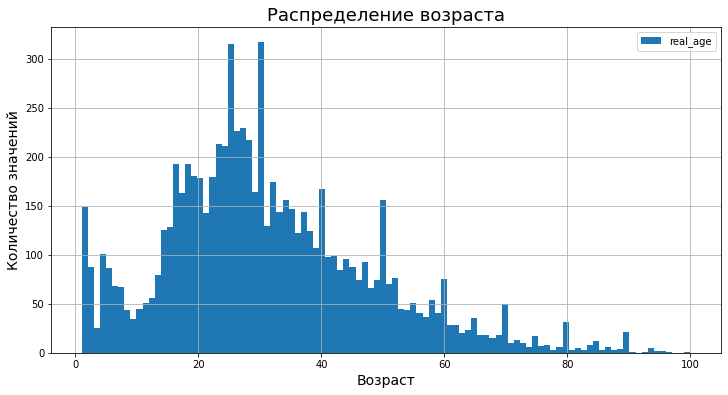

In [7]:
data.plot(kind="hist", bins=100, grid=True, figsize=(12, 6))
plt.title('Распределение возраста', fontsize=18)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество значений', fontsize=14)
plt.show()

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    seed=112263 )

Found 7591 validated image filenames.


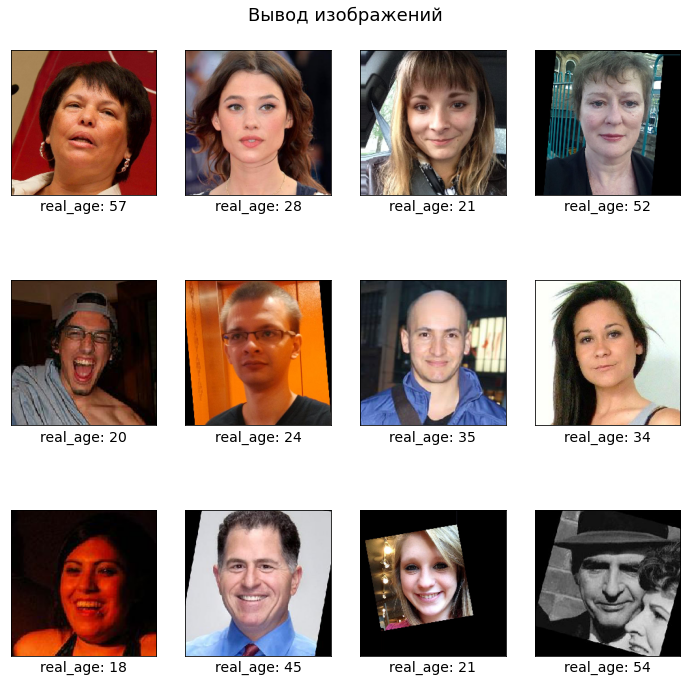

In [79]:
fig = plt.figure(figsize=(12, 12))
plt.title('Вывод изображений', fontsize=18)
plt.axis('off')

for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(features[i])
    ax.set_xlabel(f'real_age: {target[i]}', fontsize=14)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

plt.show()


Данные загружены, в предобработке не нуждаются, пропусков нет, распределение значений нормальное.  
Пик распределения возраста приходится на ~30 летие. На графике распределения замечены всплески в районе "круглых" возрастов - 30, 40, 50 и т.д. - это может быть обусловлено, что при сборе данных возраст или округляли вели измерение возрастными группами.  
Некоторые фото немного повернуты или обрезаны, качество самих фото так же разнится, может быть изменена цвет корр. Так же на некоторых фото встречаются несколько личностей, или снимки сделаны не в профиль, а с разворотом, или же и вовсе в полный рост, что может осложнить обучение. Всего в датасете порядка 7600 изображений. 

## Обучение нейронной сети и рассчет ее качества

За основу была взята архитектура ResNet50. некоторые параметры обучения модели закоментированы, поскольку опытным путем было выявлено, что такие параметры аугментации только вредят корректному оубчению модели.  
Обучение нейронной сети было выполнено следующим кодом:

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers
from keras import losses
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np



def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255.,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=15
        # zoom_range=0.15,
        # shear_range=0.15,
        # width_shift_range=0.2,
        # height_shift_range=0.2
        )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        # class_mode='sparse',
        subset='training',
        seed=112263)
    return train_datagen_flow


def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255., 
        validation_split=0.25)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        # class_mode='sparse',
        subset='validation',
        seed=112263)

    return test_datagen_flow


def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model.add(backbone)
    model.add(Conv2D(
                filters=60,
                kernel_size=(5, 5),
                padding="same",
                activation="relu",
                input_shape=input_shape)
    )
    model.add(AvgPool2D(pool_size=(2, 2)))  

    model.add(Flatten())
    model.add(Dense(units=10, activation="relu"))
    model.add(Dense(units=1, activation="relu"))

    optimizer = Adam(lr=0.0005)
    # mae = keras.losses.MeanAbsoluteError(name='mae')
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
    steps_per_epoch=None, validation_steps=None):
#     model.fit(train_data, validation_data=test_data, batch_size=batch_size,
#         epochs=epochs, steps_per_epoch=steps_per_epoch,
#         validation_steps=validation_steps,
#         verbose=2, shuffle=True)
    history = model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    
    print(history.history['loss'])
    print(history.history['mae'])
    print(history.history['val_loss'])
    print(history.history['val_mae'])
        

    return model


```

```
Результат вывода:

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-07-13 18:04:10.087695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-13 18:04:10.621969: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 103s - loss: 203.6509 - mae: 10.9071 - val_loss: 577.1807 - val_mae: 19.0494
Epoch 2/10
178/178 - 96s - loss: 130.0024 - mae: 8.6517 - val_loss: 417.4408 - val_mae: 15.4272
Epoch 3/10
178/178 - 96s - loss: 111.0686 - mae: 8.0226 - val_loss: 518.9999 - val_mae: 17.7076
Epoch 4/10
178/178 - 96s - loss: 93.9526 - mae: 7.3509 - val_loss: 233.6473 - val_mae: 11.2191
Epoch 5/10
178/178 - 95s - loss: 84.5120 - mae: 6.9326 - val_loss: 139.2074 - val_mae: 9.0870
Epoch 6/10
178/178 - 96s - loss: 67.7058 - mae: 6.2343 - val_loss: 108.1259 - val_mae: 7.9483
Epoch 7/10
178/178 - 96s - loss: 65.2940 - mae: 6.1562 - val_loss: 160.1600 - val_mae: 9.4285
Epoch 8/10
178/178 - 96s - loss: 59.4794 - mae: 5.9075 - val_loss: 88.3490 - val_mae: 7.0417
Epoch 9/10
178/178 - 96s - loss: 48.2250 - mae: 5.3374 - val_loss: 78.8448 - val_mae: 6.6003
Epoch 10/10
178/178 - 93s - loss: 44.7286 - mae: 5.1217 - val_loss: 86.8663 - val_mae: 6.8052
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 86.8663 - mae: 6.8052
Test MAE: 6.8052

```

## Анализ обученной модели

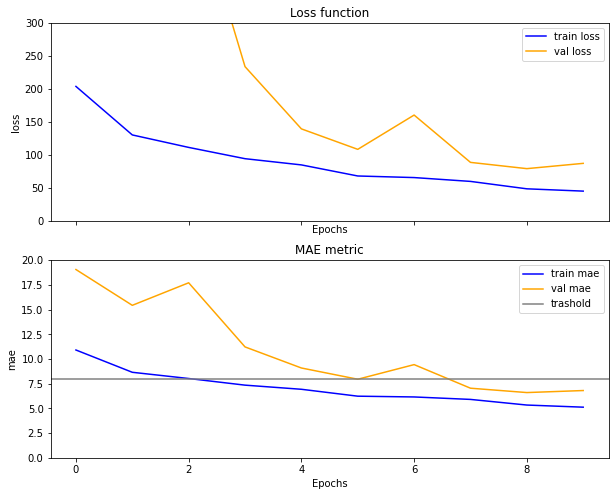

In [4]:
# логи и графики 

log_loss=[203.6509, 130.0024,111.0686,93.9526,84.5120,67.7058,65.2940,59.4794,48.2250,44.7286]
log_mae=[10.9071,8.6517,8.0226,7.3509,6.9326,6.2343,6.1562,5.9075,5.3374,5.1217]
log_val_loss=[577.1807,417.4408,518.9999,233.6473,139.2074,108.1259,160.1600,88.3490,78.8448,86.8663]
log_val_mae=[19.0494,15.4272,17.7076,11.2191,9.0870,7.9483,9.4285,7.0417,6.6003,6.8052]

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax.plot(log_loss, label='train loss', color='blue')
ax.plot(log_val_loss, label='val loss', color='orange')

ax.set_ylabel('loss')
ax.set_xlabel('Epochs')
ax.set_title('Loss function')
ax.set_ylim(0, 300)
# ax.title('Loss func')
ax.legend(fontsize=10)


ax1.plot(log_mae, label='train mae', color='blue')
ax1.plot(log_val_mae, label='val mae', color='orange')

ax1.set_ylabel('mae')
ax1.set_xlabel('Epochs')
ax1.set_title('MAE metric')
ax1.set_ylim(0, 20)

ax1.axhline(8, color='gray', label='trashold')
ax1.legend(fontsize=10)

plt.show()

Основой модели выбал выбрана архитектура `ResNet50`, функцией потерь была выбрана `MSE`, а ключевой метрикой `MAE`. 
В результате обучения удалось достичь результата на тестовой выборке `MAE=6.8052`, что является хорошим результатом. 
Вероятно, можно достичь лучшего результата при более качественном датасете и выборке обучения модели. 

## Вывод

Была проведена работа по исследованию данных, предобработка не потребовалась, пропусков нет, датасет насчитывает порядка 7600 фото персон разного возраста. В датасете имеются всплески возрастных групп, а так же качество фото разное, поскольку снимки сделаны в разных условиях, что могло и сказалось на обучении модели. Однако несмотря на все погрешности качества фото в датасете, удалось достичь метрики `МАЕ=6.8052`, что можно считать хороши результатом. 